# Feature Engineering

This notebook works with:

- Concatenated data from the 2 time periods of Planet and ERA-5 for filling the gap

  * Reads cleaned and concatenated data from Planet and ERA-5 
  * Calculates climatology for Soil Water Content
  * Calculates anomaly and negative anomaly

After those steps:
  * Stores the data as a NetCDF file


In [24]:
import sys
import os
cp = '/home/jupyter-gabriel/' #'I:/My Drive/'
sys.path.append(cp + "projects/suyana")
from scripts.utils.functions import *

In [25]:
# Data primary path
dpp = 'suyana/'
# Data inputs path
dip = 'suyana/inputs/'
# Data features path
dfp = 'suyana/features/'
# Data outputs path
dop = 'suyana/outputs/'
# Data reports path
drp = 'suyana/reports/'
# Data models path
dmp = 'suyana/models/'
# Data displays path
ddp = 'suyana/displays/'
# Data geometries path
dgp = 'suyana/geometries/'

In [26]:
def add_climatology(ds, field, time_dim = 'time', dims = None):
    # Get full years only to calculate the climatology
    # Group by year and count the number of dates
    ds_days_per_year = ds[time_dim].groupby(time_dim+".year").count()

    # Filter for full years
    full_years = ds_days_per_year.where(ds_days_per_year >= 365).dropna('year')
    ds_full = ds.sel(time=ds["time.year"].isin(full_years.year))
    
    if dims == None:
        dims = [time_dim]

    if not set(dims).issubset(set(list(ds.sizes.keys()))):
        raise ValueError(f"Input for dims must be a subset of dimensions")

    climatology = ds_full[field].groupby(time_dim+".dayofyear").mean(dims)
    ds["climatology"] = xr.DataArray(
        climatology.sel(dayofyear=ds[time_dim+".dayofyear"]), 
        dims=list(ds.sizes.keys())
    )

    return ds


In [27]:
def add_anomaly(ds, field):
    # ds["swc"] = ds["swc_adjusted"].rolling(time=21, min_periods=1).mean()
    # First value will not be filled if it is nan, so drop it
    if ds[field].isel(time=0).isnull().any():
        ds = ds.isel(time=slice(1, None))
    ds["anomaly"] = ds[field] - ds["climatology"]
    ds["negative_anomaly"] = ds["anomaly"].where(ds["anomaly"] < 0, np.nan) * (-1)
    ds["negative_anomaly"] = ds["negative_anomaly"].fillna(0)

    return ds

In [28]:
def add_crop_cycles(ds, time_dim):
    ds["crop_cycle"] = 2001 + (ds[time_dim].dt.year - 2002) + (ds[time_dim].dt.month >= 11)
    mask_feb = (ds[time_dim].dt.month == 2) & (ds[time_dim].dt.day >= 16)
    mask_mar_oct = (ds[time_dim].dt.month >= 3) & (ds[time_dim].dt.month <= 10)
    mask = mask_feb | mask_mar_oct
    ds["crop_cycle"] = ds["crop_cycle"].where(~mask)
    ds = ds.set_coords("crop_cycle")
    return ds


In [29]:
def add_crop_cycles(ds, time_dim):
    # Add a crop_year coordinate and a flag of summer campaign
    ds["crop_year"] = (ds[time_dim] - np.timedelta64(4, 'm')).dt.year
    ds["flag_summer"] = xr.where(ds[time_dim].dt.month.isin([11,12,1,2,3,4]),1,0)

    # Add a crop_cycle coordinate
    ds["crop_cycle"] = 2001 + (ds[time_dim].dt.year - 2002) + (ds[time_dim].dt.month >= 11)
    mask_feb = (ds[time_dim].dt.month == 2) & (ds[time_dim].dt.day >= 16)
    mask_mar_oct = (ds[time_dim].dt.month >= 3) & (ds[time_dim].dt.month <= 10)
    mask = mask_feb | mask_mar_oct
    ds["crop_cycle"] = ds["crop_cycle"].where(~mask)

    ds = ds.set_coords(["crop_year", "flag_summer", "crop_cycle"])
    return ds


# Create anomaly and climatology for each dataset

In [31]:
# Read the yields panel dataset to clean only the required values of canton
df_yields_final = pd.read_csv(dip + 'drought_yields_panel_id.csv')

In [32]:
import os
path = dpp + "drought/swc/raw/"
files = os.listdir(path)
files = [f for f in files if f.startswith("canton")]
id_canton = [files[i].split("_")[1] for i in range(len(files))]

list_ids = sorted(list(set(df_yields_final['id_canton'].astype(str)).intersection(set(id_canton))))
list_ids

['189', '195', '209', '43', '49', '52', '54', '56', '57']

In [33]:
ds = xr.open_dataset(dip + 'drought_canton_processed_' + str(43) + '.nc')

ds = add_climatology(ds, 'swc_adjusted')
ds = add_anomaly(ds, 'swc_adjusted')
ds = add_crop_cycles(ds, 'time')

In [34]:
dims = None
ds_days_per_year = ds['time'].groupby('time'+".year").count()

# Filter for full years
full_years = ds_days_per_year.where(ds_days_per_year >= 365).dropna('year')
ds_full = ds.sel(time=ds["time.year"].isin(full_years.year))

if dims == None:
    dims = ['time']

if not set(dims).issubset(set(list(ds.sizes.keys()))):
    raise ValueError(f"Input for dims must be a subset of dimensions")

climatology = ds_full['swc_adjusted'].groupby('time'+".dayofyear").mean(dims)
ds["climatology"] = xr.DataArray(
    climatology.sel(dayofyear=ds['time'+".dayofyear"]), 
    dims=list(ds.sizes.keys())
)

In [35]:
climatology

<xarray.DataArray 'swc_adjusted' (dayofyear: 366, lat: 17, lon: 12)> Size: 597kB
array([[[0.19865926, 0.19865926, 0.19865926, ..., 0.23415829,
         0.20655556, 0.23795238],
        [0.19865926, 0.19865926, 0.19865926, ..., 0.23903795,
         0.24069788, 0.24365203],
        [0.20362698, 0.20362698, 0.20362698, ..., 0.24350021,
         0.24515886, 0.24636839],
        ...,
        [0.2193037 , 0.25676728, 0.25723   , ..., 0.24240931,
         0.24113701, 0.23799527],
        [0.2193037 , 0.25763694, 0.25604307, ..., 0.23817858,
         0.23650598, 0.23297686],
        [0.25693399, 0.25506632, 0.25188515, ..., 0.23167893,
         0.22930008, 0.22761062]],

       [[0.20214286, 0.20214286, 0.20214286, ..., 0.23251765,
         0.21092857, 0.24194017],
        [0.20214286, 0.20214286, 0.20214286, ..., 0.23822656,
         0.23880332, 0.24167918],
        [0.20743333, 0.20743333, 0.20743333, ..., 0.24283475,
         0.24363142, 0.24507221],
...
        [0.21808148, 0.25379102, 0.25342885, ..., 0.24179242,
         0.24060993, 0.23771955],
        [0.21808148, 0.25385131, 0.25216609, ..., 0.23693328,
         0.23538062, 0.23195723],
        [0.2538035 , 0.25145885, 0.24800837, ..., 0.23021665,
         0.22728208, 0.22556941]],

       [[       nan,        nan,        nan, ..., 0.24538557,
                nan,        nan],
        [       nan,        nan,        nan, ..., 0.24779725,
         0.25325429, 0.25575069],
        [       nan,        nan,        nan, ..., 0.25136286,
         0.25637291, 0.25916921],
        ...,
        [       nan, 0.25024476, 0.24951746, ..., 0.24476413,
         0.24378455, 0.24086508],
        [       nan, 0.25014476, 0.24869101, ..., 0.23988413,
         0.23875979, 0.23511979],
        [0.25129417, 0.24754804, 0.24492762, ..., 0.23503365,
         0.23115587, 0.22900508]]])
Coordinates:
  * lat        (lat) float64 136B -17.38 -17.36 -17.33 ... -17.0 -16.98 -16.95
  * lon        (lon) float64 96B -62.13 -62.1 -62.08 ... -61.89 -61.86 -61.83
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366

In [ ]:
for id in list_ids:
    print(f"Canton: {id}")

    ds = xr.open_dataset(dip + 'drought_canton_processed_' + str(id) + '.nc')

    ds = add_climatology(ds, 'swc_adjusted')
    ds = add_anomaly(ds, 'swc_adjusted')
    ds = add_crop_cycles(ds, 'time')
    print('Climatology and anomaly successfully added')

    comp = dict(zlib=True, complevel=9)
    encoding = {var: comp for var in ds.data_vars}
    
    ds.to_netcdf(
        dip + 'drought_canton_coarsened_' + str(id) +'.nc',
        encoding = encoding
    )

Canton: 189
Climatology and anomaly successfully added
Canton: 195
Climatology and anomaly successfully added
Canton: 209
Climatology and anomaly successfully added
Canton: 43
Climatology and anomaly successfully added
Canton: 49
Climatology and anomaly successfully added
Canton: 52
Climatology and anomaly successfully added
Canton: 54
Climatology and anomaly successfully added
Canton: 56
Climatology and anomaly successfully added
Canton: 57
Climatology and anomaly successfully added


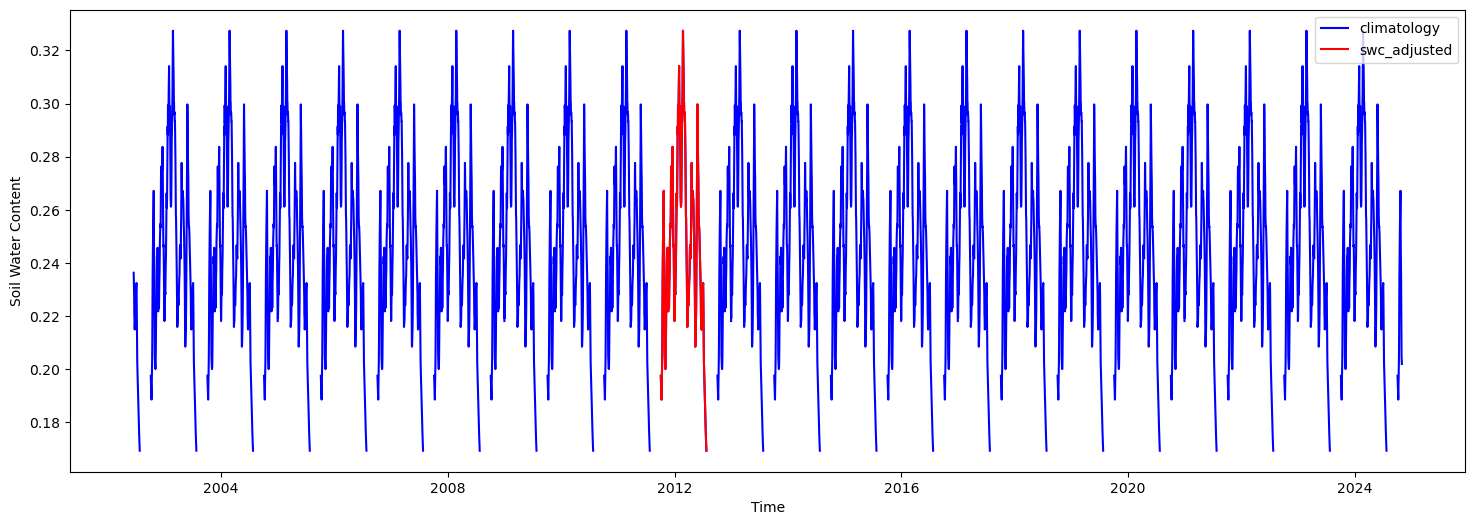

In [36]:
# Select the data at the specific location
ds_location = ds.isel(lon=0, lat=13)
#ds_location = ds_location.sel(time=slice('2010-10-01', '2013-07-31'))
# Plotting 
plt.figure(figsize=(18, 6)) 
plt.plot(ds_location.time, ds_location.climatology, label='climatology', color='blue') 
plt.plot(ds_location.time, ds_location.swc_adjusted, label='swc_adjusted', color='red')
plt.xlabel('Time') 
plt.ylabel('Soil Water Content')
plt.legend()
plt.show()

In [33]:
ds_aux= ds_location.sel(time=ds_location['time.dayofyear'].isin(list(np.arange(260,280))))

In [34]:
ds_aux.swc_adjusted.values

array([0.23174359, 0.23174359, 0.23194872, 0.24071429, 0.24052778,
       0.23662222, 0.17615385, 0.17659524, 0.17494444, 0.17659524,
       0.18138462, 0.17838462, 0.17886111, 0.17787179, 0.17579487,
       0.17505128, 0.17630769, 0.17630769, 0.17512821, 0.17402564,
       0.1735641 , 0.1735641 , 0.16223077, 0.20542222, 0.19964444,
       0.1957963 , 0.24158333, 0.23833333, 0.23641026, 0.23641026,
       0.24679487, 0.24679487, 0.26217949, 0.2635    , 0.268     ,
       0.27351282, 0.2747381 , 0.27616667, 0.27616667, 0.27580952,
       0.278     , 0.27958974, 0.28372222, 0.27725641, 0.28635897,
       0.28635897])

# Create climatology and anomaly from nearest pixel

In [37]:
# Step 1: Function to select nearest points
def select_nearest(ds, df):
    """
    Selects nearest points from the xarray.Dataset for each (lon, lat) in the DataFrame.
    """
    results = []
    for _, row in df.iterrows():
        # Select the nearest point
        nearest_point = ds.sel(lon=row["longitude"], lat=row["latitude"], method="nearest")
        results.append(nearest_point)
    return results

In [39]:
# Read the yields panel dataset to clean only the required values of canton
df_yields_final = pd.read_csv(dip+'drought_yields_panel_id.csv')

In [40]:
# Clean up date data
df_yields_final = df_yields_final.loc[~((df_yields_final.harvest_date.isna())),:].copy()

df_yields_final['harvest_date'] = pd.to_datetime(df_yields_final['harvest_date'])
df_yields_final['seed_date'] = pd.to_datetime(df_yields_final['seed_date'])

df_yields_final['crop_year'] = df_yields_final.yr
df_yields_final['flag_summer'] = df_yields_final.summer

In [41]:
df_coords = df_yields_final[['longitude', 'latitude','id_lot', 'id_canton']].drop_duplicates(
    subset=['longitude', 'latitude', 'id_canton'], keep='first'
)
list_ids = sorted(df_coords['id_canton'].unique().tolist())
list_ids

[43, 49, 52, 54, 56, 57, 189, 195, 209]

In [42]:
df = pd.DataFrame()
for id in list_ids:
    print(f"Canton: {id}")
    df_aux = df_coords[df_coords['id_canton']==id].copy()
    ds_canton = xr.open_dataset(dip + 'drought_canton_coarsened_' + str(id) +'.nc')
    ds_nearest = select_nearest(ds_canton, df_aux)
    df_result = pd.DataFrame({
        "id_lot": df_aux["id_lot"],
        "lon": df_aux["longitude"],
        "lat": df_aux["latitude"],
        "id_canton": df_aux["id_canton"],
        "nearest_lon": [point.lon.values for point in ds_nearest],
        "nearest_lat": [point.lat.values for point in ds_nearest],
        "time": [point.time.values for point in ds_nearest],
        "crop_year": [point.crop_year.values for point in ds_nearest],
        "flag_summer": [point.flag_summer.values for point in ds_nearest],
        "swc_adjusted": [point.swc_adjusted.values for point in ds_nearest],
        "climatology": [point.climatology.values for point in ds_nearest],
        "anomaly": [point.anomaly.values for point in ds_nearest],
        "negative_anomaly": [point.negative_anomaly.values for point in ds_nearest],
    })
    df_result = df_result.explode(['time', 'crop_year', 'flag_summer','swc_adjusted', 'climatology', 'anomaly', 'negative_anomaly'], ignore_index= True)
    df = pd.concat([df, df_result], axis=0)

Canton: 43
Canton: 49
Canton: 52
Canton: 54
Canton: 56
Canton: 57
Canton: 189
Canton: 195
Canton: 209


In [43]:
df_final = df.copy()

In [ ]:
df_final['nearest_lon'] = df_final['nearest_lon'].astype(float)
df_final['nearest_lat'] = df_final['nearest_lat'].astype(float)
df_final['swc_adjusted'] = df_final['swc_adjusted'].astype(float)
df_final['climatology'] = df_final['climatology'].astype(float)
df_final['anomaly'] = df_final['anomaly'].astype(float)
df_final['negative_anomaly'] = df_final['negative_anomaly'].astype(float)

In [51]:
df_final.to_parquet(dfp + 'drought_anomalies_regression.parquet', compression='gzip')

# Final yields_panel data

In [52]:
df_final = pd.read_parquet(dfp + 'drought_anomalies_regression.parquet')
df_final.head(4)

,id_lot,lon,lat,id_canton,nearest_lon,nearest_lat,time,crop_year,flag_summer,swc_adjusted,climatology,anomaly,negative_anomaly
0,51,-61.93275,-17.08809,43,-61.941441,-17.085586,2002-06-16,2002,0,0.364759,0.274799,0.089960,0.0
1,51,-61.93275,-17.08809,43,-61.941441,-17.085586,2002-06-17,2002,0,0.339487,0.275575,0.063912,0.0
2,51,-61.93275,-17.08809,43,-61.941441,-17.085586,2002-06-18,2002,0,0.337667,0.273217,0.064450,0.0
3,51,-61.93275,-17.08809,43,-61.941441,-17.085586,2002-06-19,2002,0,0.316200,0.273198,0.043002,0.0


In [53]:
# Get the nearest anomaly crop cycle
df_anomalies = df_final.groupby(['lon', 'lat', 'crop_year', 'flag_summer']).agg(
    accum_cycle_neg_anomaly = ('negative_anomaly', 'sum'),
    accum_cycle_anomaly = ('anomaly', 'sum'),
).reset_index()
df_anomalies.head(3)

,lon,lat,crop_year,flag_summer,accum_cycle_neg_anomaly,accum_cycle_anomaly
0,-63.48737,-16.36514,2002,0,6.711689,-6.711689
1,-63.48737,-16.36514,2002,1,1.411225,-0.904553
2,-63.48737,-16.36514,2003,0,4.225493,-3.536853


In [54]:
# Add anomalies to yields data
df_aux = df_yields_final[['longitude','latitude', 'crop_year', 'flag_summer', 'harvest_date', 'seed_date']].copy()
df_join = df_aux.merge(
    df_final[['lon', 'lat', 'anomaly', 'negative_anomaly', 'time']],
    how = "left",
    left_on = ["longitude", "latitude"],
    right_on = ["lon", "lat"]
).drop(['lon', 'lat'], axis = 1)

df_join = df_join.query(
    "time >= seed_date & time <= harvest_date"
)

#df_join = df_join.sort_values(by='time', axis=1)
df_join = df_join.groupby(['longitude', 'latitude', 'crop_year', 'flag_summer']).agg(
    accum_anomaly = ('anomaly', 'sum'),
    accum_neg_anomaly = ('negative_anomaly', 'sum')
).reset_index()

df_yields_final = df_yields_final.merge(
    df_join,
    how = 'left',
    on = ['longitude', 'latitude', 'crop_year', 'flag_summer']
)

df_yields_final = df_yields_final.merge(
    df_anomalies,
    how = 'left',
    left_on = ['longitude', 'latitude', 'crop_year', 'flag_summer'],
    right_on = ['lon', 'lat', 'crop_year', 'flag_summer'],
)

#df_yields_final[['longitude', 'latitude', 'seed_date', 'harvest_date', 'accum_anomaly', 'accum_neg_anomaly', 'accum_cycle_neg_anomaly', 'accum_cycle_anomaly']].head(3)

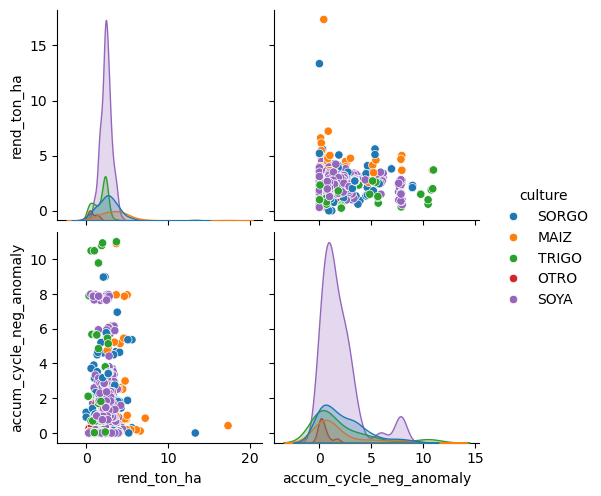

In [55]:
sns.pairplot(
    df_yields_final.loc[df_yields_final['flag_summer'].isin([0,1]),['rend_ton_ha', 'accum_cycle_neg_anomaly','culture']], 
    hue='culture'
)

In [59]:
df_yields_final.to_csv(dfp + 'drought_yields_panel_final.csv', index=False)

# Anomalies for recent crop years

In [57]:
df_anomalies.head(3)

,lon,lat,crop_year,flag_summer,accum_cycle_neg_anomaly,accum_cycle_anomaly
0,-63.48737,-16.36514,2002,0,6.711689,-6.711689
1,-63.48737,-16.36514,2002,1,1.411225,-0.904553
2,-63.48737,-16.36514,2003,0,4.225493,-3.536853


In [58]:
df_anomalies['trigger'] = np.where(df_anomalies['accum_cycle_neg_anomaly'] >= 3.68, 1, 0)

In [26]:
df_summary = df_anomalies.loc[df_anomalies['flag_summer']==1,:].groupby('crop_year').agg(
    n_count = ('lon', 'count'),
    n_triggers = ('trigger', 'sum')
).reset_index()
df_summary['perc_trigger'] = df_summary['n_triggers']/df_summary['n_count']
df_summary

,crop_year,n_count,n_triggers,perc_trigger
0,2002,107,0,0.000000
1,2003,107,0,0.000000
2,2004,107,102,0.953271
3,2005,107,33,0.308411
4,2006,107,0,0.000000
...,...,...,...,...
18,2020,107,62,0.579439
19,2021,107,0,0.000000
20,2022,107,32,0.299065
21,2023,107,47,0.439252


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


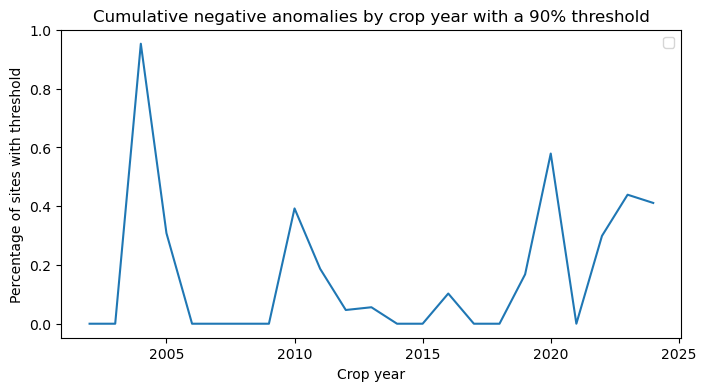

In [29]:
# Create scatter plot
plt.figure(figsize=(8, 4))
sns.lineplot(data=df_summary, x='crop_year', y='perc_trigger')

# Add a constant horizontal line at y = 3.68
#plt.axhline(y=3.68, color="red", linestyle="--", label="y = 10")

# Labels and legend
plt.xlabel("Crop year")
plt.ylabel("Percentage of sites with threshold")
plt.title("Cumulative negative anomalies by crop year with a 90% threshold")
plt.legend()
plt.show()

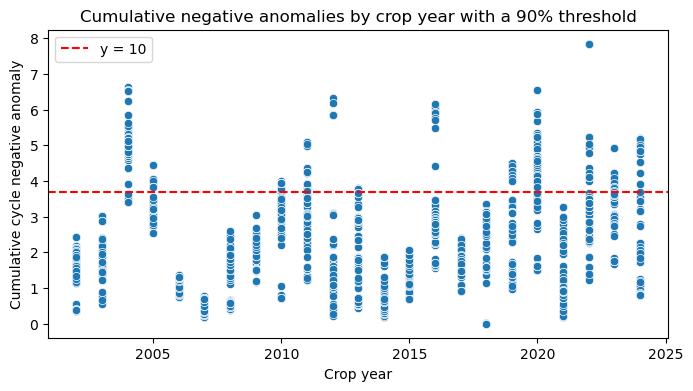

In [27]:
# Create scatter plot
plt.figure(figsize=(8, 4))
sns.scatterplot(data=df_anomalies.loc[df_anomalies['flag_summer']==1,:], x='crop_year', y='accum_cycle_neg_anomaly')

# Add a constant horizontal line at y = 3.68
plt.axhline(y=3.68, color="red", linestyle="--", label="y = 10")

# Labels and legend
plt.xlabel("Crop year")
plt.ylabel("Cumulative cycle negative anomaly")
plt.title("Cumulative negative anomalies by crop year with a 90% threshold")
plt.legend()
plt.show()